In [1]:
#TASK-0

In [2]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os

import torch.optim as optim

In [4]:
transformations = transforms.Compose([
    transforms.RandomRotation(degrees = 15),
    transforms.RandomCrop(size=28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

mnist_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transformations)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])


In [5]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(datasets.MNIST(root="./data", train=False, download=True, transform=transformations),
                         batch_size=10, shuffle=False)


In [6]:
#TASK-1

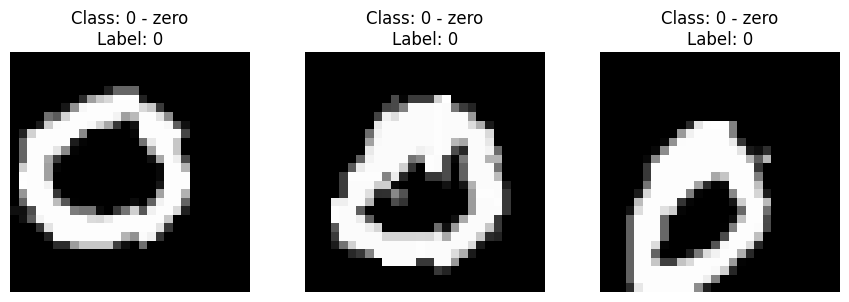

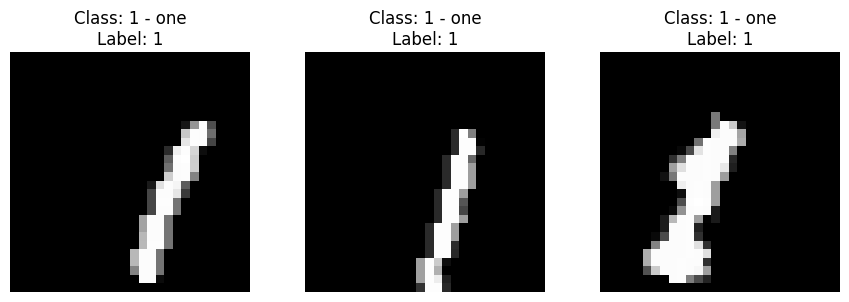

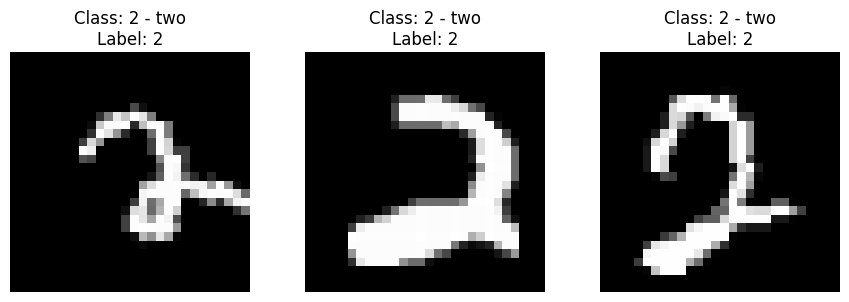

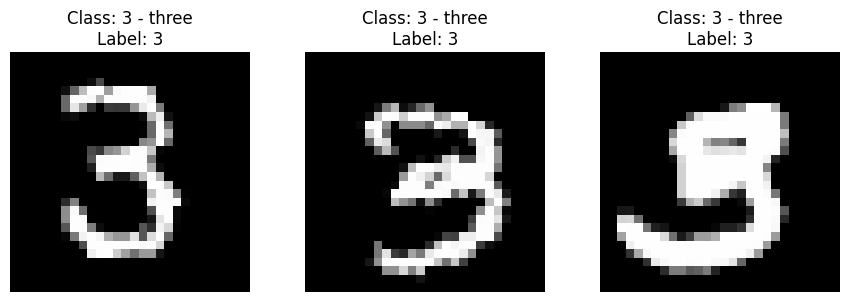

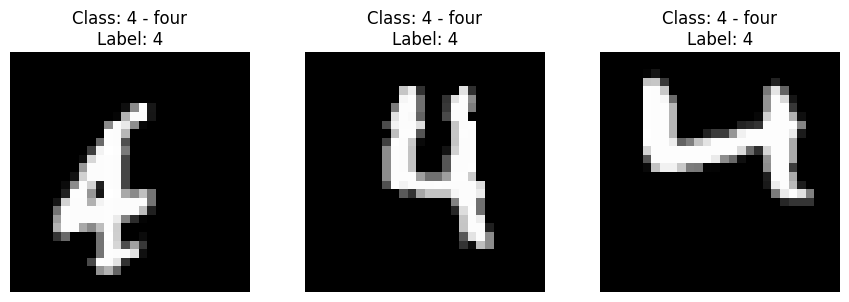

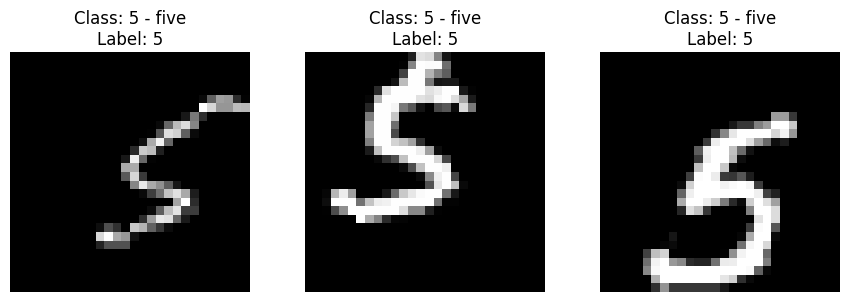

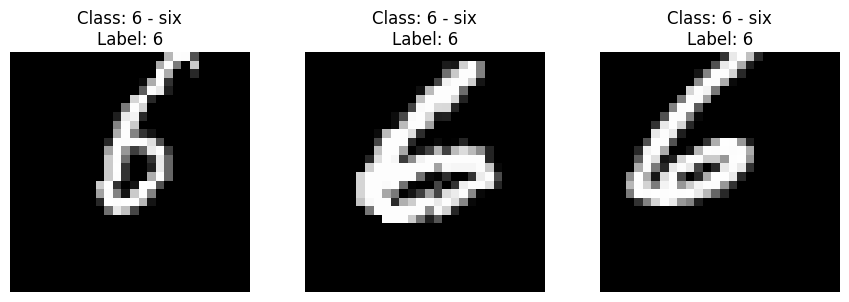

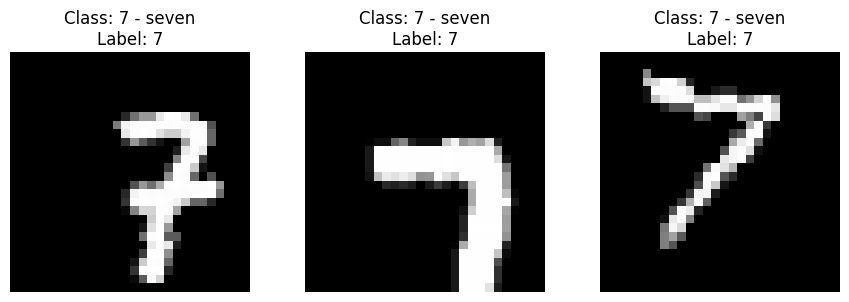

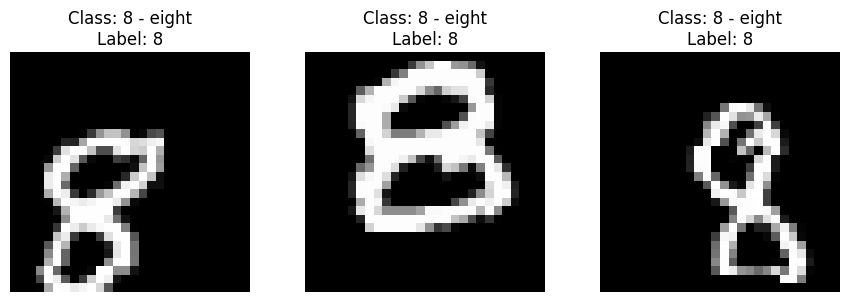

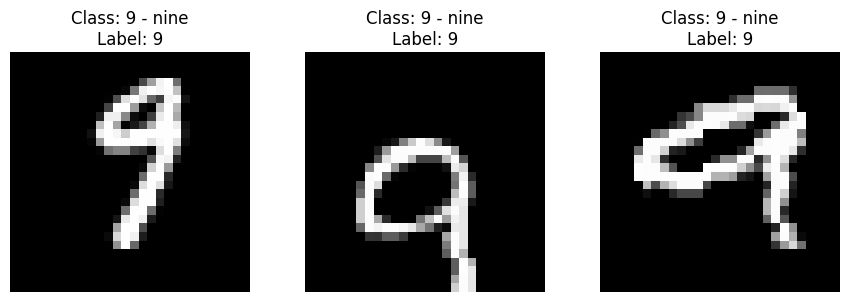

In [7]:
def plot_images_per_class(loader, classes, num_images=3):
    images_per_class = [[] for _ in range(len(classes))]
    labels_per_class = [[] for _ in range(len(classes))]

    for images, labels in loader:
        for image, label in zip(images, labels):
            images_per_class[label.item()].append(image)
            labels_per_class[label.item()].append(label.item())

    for i, class_name in enumerate(classes):
        class_images = images_per_class[i][:num_images]
        class_labels = labels_per_class[i][:num_images]

        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
        for ax, image, label in zip(axes, class_images, class_labels):
            ax.imshow(image.squeeze(), cmap='gray')
            ax.set_title(f"Class: {class_name}\nLabel: {label}")
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Plot images from the training set
plot_images_per_class(train_loader, mnist_dataset.classes)

In [8]:
 
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)  # Flatten input tensor if it's not already flattened
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Function to create and print the model
def create_and_print_model():
    input_size = 28 * 28  # MNIST image size (28x28)
    hidden_size1 = 128
    hidden_size2 = 64
    output_size = 10  # Number of classes in MNIST

    # Create an instance of the MLP model
    model = MLP(input_size, hidden_size1, hidden_size2, output_size)

    # Print the number of trainable parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_params}")
    print(model)

# Call the function to create and print the model
create_and_print_model()


Number of trainable parameters: 109386
MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, save_dir='./saved_models'):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0.0
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            save_path = os.path.join(save_dir, 'best_model.pth')
            torch.save(model.state_dict(), save_path)
            print("Best model saved.")

        # Plot Loss-Epoch and Accuracy-Epoch graphs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss-Epoch Graph')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accs, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy-Epoch Graph')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [10]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    predictions = []
    ground_truth = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.tolist())
            ground_truth.extend(labels.tolist())
    
    accuracy = correct / total
    avg_loss = running_loss / len(data_loader)
    return accuracy, avg_loss, predictions, ground_truth


In [11]:
input_size = 28 * 28  # MNIST image size (28x28)
hidden_size1 = 128
hidden_size2 = 64
output_size = 10  # Number of classes in MNIST
learning_rate = 0.001
batch_size = 64
num_epochs = 5

Epoch 1/5:
Training Loss: 1.0400, Training Accuracy: 0.6475
Validation Loss: 0.6534, Validation Accuracy: 0.7873
Best model saved.
Epoch 2/5:
Training Loss: 0.5833, Training Accuracy: 0.8136
Validation Loss: 0.5004, Validation Accuracy: 0.8375
Best model saved.
Epoch 3/5:
Training Loss: 0.4948, Training Accuracy: 0.8433
Validation Loss: 0.4882, Validation Accuracy: 0.8503
Best model saved.
Epoch 4/5:
Training Loss: 0.4550, Training Accuracy: 0.8555
Validation Loss: 0.4806, Validation Accuracy: 0.8483
Epoch 5/5:
Training Loss: 0.4225, Training Accuracy: 0.8662
Validation Loss: 0.4154, Validation Accuracy: 0.8728
Best model saved.


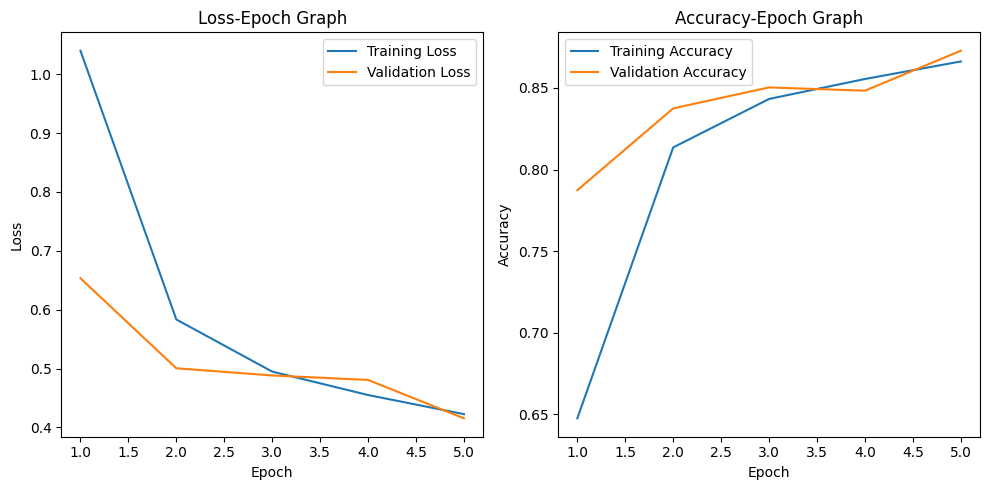

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [12]:
model = MLP(input_size, hidden_size1, hidden_size2, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Evaluate the best model on the test set
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transformations)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

best_model = MLP(input_size, hidden_size1, hidden_size2, output_size)
best_model.load_state_dict(torch.load('./saved_models/best_model.pth'))
best_model.eval()



In [13]:
test_acc, test_loss, test_predictions, test_ground_truth = evaluate_model(best_model, test_loader, criterion)

print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.8735
